In [1]:
import yaml
from tqdm import tqdm
import numpy as np
import timeit
import os
import glob
import pandas as pd
from dateutil.parser import parse
import json


import torch
import matplotlib.pyplot as plt
import json
from collections import defaultdict

from KERN.model.KERN import KERN
from KERN.model.KERN_oms import KERN_oms

In [2]:
conf = yaml.load(open("KERN/config.yaml"), Loader=yaml.FullLoader)
dataset_name = "omnious"
conf = conf[dataset_name]
conf["dataset"] = dataset_name


# conf['data_path'] = 'KERN/dataset/omnious/12072021_auto_All_data.json'
# conf['data_norm_path'] = 'KERN/dataset/omnious/12072021_auto_All_data_norm.json'

conf['data_path'] = 'KERN/dataset/omnious/07072021_auto_data.json'
conf['data_norm_path'] = 'KERN/dataset/omnious/07072021_auto_data_norm.json'

conf['dist_mat_path'] = 'KERN/dataset/omnious/07072021_auto_dist_mat_ver2.npy'
conf['log'] = "./KERN/log"

# Temporarilty
# conf['batch_size'] = 1
print(conf)

{'data_path': 'KERN/dataset/omnious/07072021_auto_data.json', 'data_norm_path': 'KERN/dataset/omnious/07072021_auto_data_norm.json', 'dist_mat_path': 'KERN/dataset/omnious/07072021_auto_dist_mat_ver2.npy', 'fashion_data_path': './dataset/omnious/01072021_auto_fashion_data.json', 'fashion_data_norm_path': './dataset/omnious/01072021_auto_fashion_data_norm.json', 'input_len': 12, 'output_len': 4, 'ext_kg': False, 'int_kg': False, 'triplet_lambda': 0.0002, 'sample_range': 100, 'use_grp_embed': True, 'lr': 0.001, 'lr_decay_interval': 20, 'lr_decay_gamma': 0.1, 'test_interval': 1, 'optimizer': 'adam', 'epoch': 20, 'batch_size': 400, 'feat_size': 10, 'rnn_hidden_size': 50, 'denorm': False, 'lr_scheduler': 'Plateau', 'log': './KERN/log', 'dataset': 'omnious'}


In [3]:

if dataset_name == "fit":
    from KERN.utility import TrendData
elif dataset_name == "omnious":
    from KERN.utility_omnious import TrendData

dataset = TrendData(conf)
conf["grp_num"] = len(dataset.grp_id_map)
conf["ele_num"] = len(dataset.ele_id_map)
conf["time_num"] = dataset.time_num
if dataset_name == "fit":
    conf["city_num"] = len(dataset.city_id_map)
    conf["gender_num"] = len(dataset.gender_id_map)
    conf["age_num"] = len(dataset.age_id_map)
elif conf["dataset"] == "omnious":
    conf["location_num"] = len(dataset.location_id_map)
    conf["segment_num"] = len(dataset.segment_id_map)
    conf["target_age_num"] = len(dataset.target_age_id_map)

device = "cuda:0"
conf["device"] = device


 __init__ TrendData 
 get_ori_data 
length of trends & ele_ids 43141 43141
 preprocess_data 
train data:  (2933588, 16, 2)
test data:  (43141, 16, 2)
(2933588,) (2933588,) (2933588,) (2933588,)


In [4]:
# model
if dataset_name == "fit":
    model = KERN(conf, dataset.adj)
    weights = 'runs/exp5_fit_24__/weights/best.pt'
elif conf["dataset"] == "omnious":
    model = KERN_oms(conf)
    #weights = 'KERN/runs/exp17_omnious_4__IntKG_lambda:0.000200__SampleRange:50in12out4_nosparse_plateau/weights/best.pt'
    #weights = 'KERN/runs/exp31_omnious_4__IntKG_lambda:0.000200__SampleRange:50in12out4/weights/best.pt'
    #weights = 'KERN/runs/exp45_omnious_4__IntKG_lambda:0.000200__SampleRange:50in12out4_1406data_Plateau/weights/best.pt'
    #weights = 'KERN/ru6_merged_data_Plateau-new_dist_mat/weights/best.pt'
    #weights = 'KERN/runs/exp102_omnious_4__IntKG_lambda:0.000200__SampleRange:100in12out4_0107_auto_data/weights/best.pt'ns/exp78_omnious_4__IntKG_lambda:0.002000__SampleRange:100in12out4_2106data_Plateau-new_dist_mat/weights/best.pt'
    #weights = 'KERN/runs/exp82_omnious_4__in12out4_210
    
    
    weights = 'KERN/runs/exp108_omnious_4__IntKG_lambda:0.000200__SampleRange:100in12out4_0707_auto_merged_50sparse_data/weights/best.pt' 
    #weights = 'KERN/runs/exp112_omnious_4__in12out4_1207_auto_All_data/weights/best.pt'
model.to(device)

# load weights
ckpt = torch.load(weights, map_location=device)
state_dict = ckpt['model']
model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [5]:
def date2week(upload_date):
    # e.g. upload_date =  "2020-11-14 10:27:43"
    ymd = upload_date.split()[0]
    date_series = pd.Series([ymd])
    date_series = date_series.map(lambda x: parse(x))
    [week_no] = date_series.dt.isocalendar().week.tolist()
    last_week_2019 = 20191229  #"2019-12-29" # 52
    last_week_2020 = 20210103 #"2021-01-03" # 53
    [year, month, day] = ymd.split("-")
    ymd = int(year+month+day)
    # print("relative week", week_no)
    if ymd > last_week_2019 and ymd < last_week_2020:
        week_no += 52
    elif ymd > last_week_2020:
        week_no += 52 + 53
    week_no -= 44
    return week_no

In [6]:
dataset_path = '/home/omnious/workspace/yeskendir/KERN/'
logdir = os.path.join(dataset_path, 'log/' + conf["data_path"].split('/')[-1].split('.')[0])
location_filename = os.path.join(logdir, "location_id_map.json")
segment_filename = os.path.join(logdir, "segment_id_map.json")
target_age_filename = os.path.join(logdir, "target_age_id_map.json")
ele_filename = os.path.join(logdir, "ele_id_map.json")
grp_filename = os.path.join(logdir, "grp_id_map.json")

with open(location_filename) as location_file:
    location_id_map = json.load(location_file)

with open(segment_filename) as segment_file:
    segment_id_map = json.load(segment_file)

with open(target_age_filename) as target_age_file:
    target_age_id_map = json.load(target_age_file)
    
with open(ele_filename) as ele_file:
    ele_id_map = json.load(ele_file)

with open(grp_filename) as grp_file:
    grp_id_map = json.load(grp_file)

trends_data_file = "/home/omnious/workspace/yeskendir/" + conf["data_path"] #12072021_auto_All_data.json"
with open(trends_data_file) as trends_json:
    trends_data = json.load(trends_json)

norm_data_file = "/home/omnious/workspace/yeskendir/" + conf["data_norm_path"] #12072021_auto_All_data_norm.json"
with open(norm_data_file) as norm_json:
    norm_data = json.load(norm_json)
#trends_data['location:All__segment:All__target_age:All']['color:Black']

In [7]:
def denorm(seq, norms):
    
    [min_v, max_v, eps] = norms
    temp_seq = [x[1] for x in seq]
    temp_axis = [x[0] for x in seq]
    denorm_pred = [x * (max_v - min_v) + min_v for x in temp_seq]
    denorm_res = []
    for i in range(len(temp_axis)):
        denorm_res.append([temp_axis[i], denorm_pred[i]])
    
    return denorm_res

In [8]:
device = "cuda:0"
def inference(group_name, fashion_element, upload_date, denorm_flag = True):
    time_point = date2week(upload_date)
    trends = np.array(trends_data[group_name][fashion_element])
    # 13 <= time_point <= 84
    input_len = conf["input_len"]
    output_len = conf["output_len"]
    comps = group_name.split("__")
    for each in comps:
        if "location:" in each:
            location_id = torch.LongTensor([np.array([location_id_map[each]])]).to(device)         
        if "segment:" in each:
            segment_id = torch.LongTensor([np.array([segment_id_map[each]])]).to(device)
        if "target_age:" in each:
            target_age_id = torch.LongTensor([np.array([target_age_id_map[each]])]).to(device)
    
    ele_id = torch.LongTensor([np.array([ele_id_map[fashion_element]])]).to(device)
    grp_id = torch.LongTensor([np.array([grp_id_map[group_name]])]).to(device)
    input_seq = torch.Tensor(trends[time_point:time_point + input_len]).to(device)
    output_seq = torch.Tensor(trends[time_point - output_len: time_point]).to(device)
    
    input_seq = torch.unsqueeze(input_seq, 0)
    output_seq = torch.unsqueeze(output_seq, 0)
    
    
    self_cont = [input_seq, output_seq, grp_id, ele_id, _, location_id, segment_id, target_age_id]
#     print("location_id = ", location_id, "segment_id = ", segment_id, "target_age_id = ", target_age_id, "ele_id = ", ele_id)
#     print("input_seq = ", input_seq)
#     print("output_seq = ", output_seq)
    
    model.eval()
    [self_enc_loss, self_dec_loss, self_pred, self_enc_hidden, self_enc_output, self_dec_output] = model.predict(self_cont)
    
    #return [self_enc_loss, self_dec_loss, self_pred, self_enc_hidden, self_enc_output, self_dec_output]
    trends = trends.tolist()
    pred = self_pred.tolist()[0]
    if denorm_flag:
        norms = norm_data[group_name][fashion_element]
        trends = denorm(trends, norms)
        pred = [[0,x] for x in pred]
        pred = denorm(pred, norms)
        pred = [x[1] for x in pred]
    return trends, time_point, pred

group_name = 'location:All__segment:All__target_age:All'
fashion_element = 'color:Blue'
upload_date = "2020-04-13 02:22:28"

trends, time_point, pred = inference(group_name, fashion_element, upload_date)

In [19]:
#trends_data.keys()

Saved to  inference_plots/location:All__segment:All__target_age:All   ||   color:Blue_2020-04-13


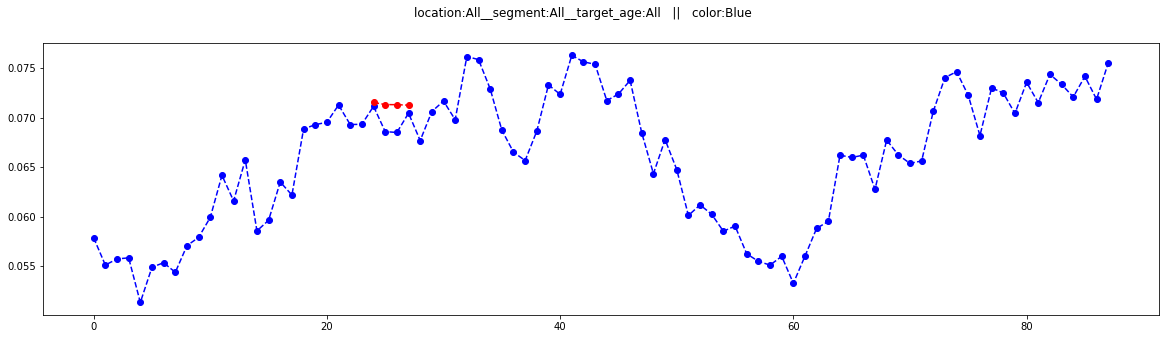

In [12]:
def visualize_inference(group_name, fashion_element, trends, upload_date, pred, save=False):
    time_point = date2week(upload_date)
    true_values = [x[1] for x in trends]
    true_x_axis = [i for i in range(len(trends))]
    
    pred_values = pred
    pred_x_axis = [time_point + x for x in range(4)]
    
    plt.figure(figsize=(20,5))
    plt.plot(true_x_axis, true_values, 'ro', linestyle='dashed', color="blue")
    plt.plot(pred_x_axis, pred_values, 'ro', linestyle='dashed', color="red")
#     title = group_name + "   ||   " + ele_name
#     plt.suptitle(title)    

#     plt.ylim((0,1.2))
    title = group_name + "   ||   " + fashion_element
    plt.suptitle(title)
    if save:
        image_filename = "inference_plots/" + title + "_" + str(upload_date.split()[0])
        plt.savefig(image_filename)
        print("Saved to ", image_filename)
    plt.show()
    
visualize_inference(group_name, fashion_element,trends, upload_date, pred, save=True)

In [11]:
def inference_and_visualize(group_name, fashion_element, upload_date):
    trends, time_point, pred = inference(group_name, fashion_element, upload_date)
    visualize_inference(trends, upload_date, pred)

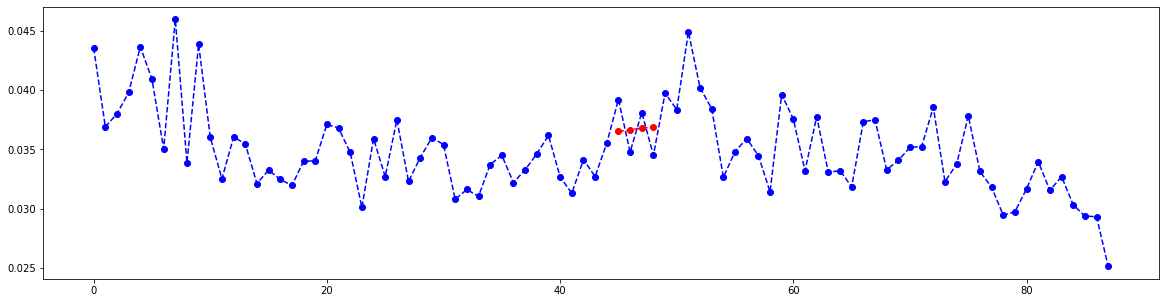

In [12]:
#group_name = 'location:All__segment:All__target_age:All'
group_name = "location:Local__segment:Micro__target_age:All"
fashion_element = 'color:Navy'
# fashion_element = 'material:Cotton'
upload_date = "2020-09-13 02:22:28"
#upload_date = "2019-11-03 18:33:22" # earliest date
#upload_date = "2021-06-22 04:30:32" # latest week

inference_and_visualize(group_name, fashion_element, upload_date)

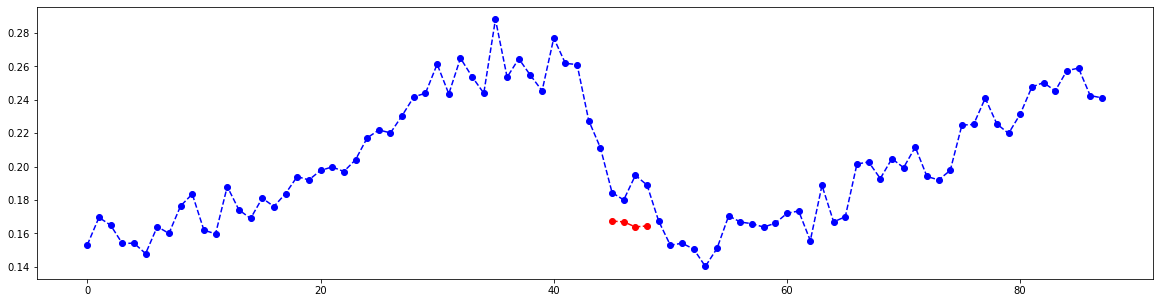

In [27]:
group_name = 'location:All__segment:Nano__target_age:All'
fashion_element = 'color:White'
upload_date = "2020-09-13 02:22:28"
#upload_date = "2019-11-03 18:33:22" # earliest date
#upload_date = "2021-06-22 04:30:32" # latest week

inference_and_visualize(group_name, fashion_element, upload_date)

'/home/omnious/workspace/yeskendir'